0
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7000000000000001
0.7500000000000001
0.8000000000000002
0.8500000000000002
0.9000000000000002
0.9500000000000003
1.0000000000000002
1.0500000000000003
1.1000000000000003
1.1500000000000004
1.2000000000000004
1.2500000000000004
1.3000000000000005
1.3500000000000005
1.4000000000000006
1.4500000000000006
1.5000000000000007
1.5500000000000007
1.6000000000000008
1.6500000000000008
1.7000000000000008
1.7500000000000009
1.800000000000001
1.850000000000001
1.900000000000001
1.950000000000001
2.000000000000001
2.0500000000000007
2.1000000000000005
2.1500000000000004
2.2
2.25
2.3
2.3499999999999996
2.3999999999999995
2.4499999999999993
2.499999999999999
2.549999999999999
2.5999999999999988
2.6499999999999986
2.6999999999999984
2.7499999999999982
2.799999999999998
2.849999999999998
2.8999999999999977
2.9499999999999975
2.9999999999999973
3.049999999999997
3.099

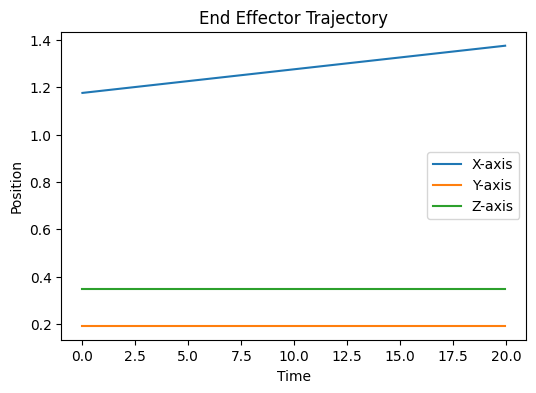

----------
0.199422666124059


In [1]:

import sympy as sp
import matplotlib.pyplot as plt

class RobotManipulator:
    def __init__(self):
        # Defining joint angle symbols
        self.theta_1, self.theta_2, self.theta_3, self.theta_4, self.theta_5, self.theta_6 = sp.symbols(
            "theta_1 theta_2 theta_3 theta_4 theta_5 theta_6")

        # Defining DH parameters.
        self.DH = [
            [self.theta_1, 0.160, 0, -sp.pi/2],
            [self.theta_2 + sp.pi/2, 0, -0.690, sp.pi],
            [self.theta_3, 0, -0.690, 0],
            [self.theta_4 + sp.pi/2, -0.195, 0, -sp.pi/2],
            [self.theta_5, 0.195, 0, -sp.pi/2],
            [self.theta_6, 0.085, 0, 0]
        ]

        # declaration of cumulative transformation matrix
        # identity matrix is declared here
        self.cumulative_transform = sp.eye(4)
        self.cumulative_matrices = []

        # Computing and assigning cumulative transformation matrices
        for i, params in enumerate(self.DH):
            self.cumulative_transform = self.cumulative_transform * self.transformation_matrix(*params, print_matrix=False)
            self.cumulative_matrices.append(self.cumulative_transform)

        # Assigning cumulative matrices to T01, T02, T03, T04, T05, and T06
        self.T01, self.T02, self.T03, self.T04, self.T05, self.T06 = self.cumulative_matrices

        # Defining J_bot for the bottom half of the Jacobian
        self.J_bot = sp.Matrix.zeros(3, 6)

        # Populating the matrix with values from the transformation matrices
        self.J_bot = sp.Matrix([
            [0, self.T01[0, 2], self.T02[0, 2], self.T03[0, 2], self.T04[0, 2], self.T05[0, 2]],
            [0, self.T01[1, 2], self.T02[1, 2], self.T03[1, 2], self.T04[1, 2], self.T05[1, 2]],
            [1, self.T01[2, 2], self.T02[2, 2], self.T03[2, 2], self.T04[2, 2], self.T05[2, 2]]
        ])

        # Taking the position components from the final transformation matrix T06 for J_top calculation.
        position_T_f_x, position_T_f_y, position_T_f_z = self.T06[0, 3], self.T06[1, 3], self.T06[2, 3]

        # Defining J_top for the top half of the Jacobian
        self.J_top = sp.Matrix.zeros(3, 6)

        # for loop for partial differentiation of position values with respect to corresponding theta values.
        for i in range(6):
            self.J_top[0, i] = position_T_f_x.diff(sp.symbols(f'theta_{i+1}'))
            self.J_top[1, i] = position_T_f_y.diff(sp.symbols(f'theta_{i+1}'))
            self.J_top[2, i] = position_T_f_z.diff(sp.symbols(f'theta_{i+1}'))

        # Jacobian matrix is obtained by stacking J_top and J_bot
        self.J = sp.Matrix.vstack(self.J_top, self.J_bot)

    def transformation_matrix(self, theta, d, a, alpha, print_matrix=True):
        T = sp.Matrix([
            [sp.cos(theta), -sp.sin(theta) * sp.cos(alpha), sp.sin(theta) * sp.sin(alpha), a * sp.cos(theta)],
            [sp.sin(theta), sp.cos(theta) * sp.cos(alpha), -sp.cos(theta) * sp.sin(alpha), a * sp.sin(theta)],
            [0, sp.sin(alpha), sp.cos(alpha), d],
            [0, 0, 0, 1]])

        if print_matrix:
            sp.pprint(T)
        return T
    
    def move_robot(self, distance, axis, q_current_initial):
               
        # declaring symbol t
        t = sp.symbols('t', real=True) 
        linear_velocity = 0.01  # in m/s
        
        # if conditions for different axes.
        if axis == 'x_axis':
            x_p = linear_velocity * t
            y_p = 0
            z_p = 0
        
        elif axis == '-x_axis':
            x_p = -linear_velocity * t
            y_p = 0
            z_p = 0
        
        elif axis == 'y_axis':
            y_p = linear_velocity * t
            x_p = 0
            z_p = 0
        
        elif axis == '-y_axis':
            y_p = -linear_velocity * t
            x_p = 0
            z_p = 0
        
        elif axis == 'z_axis':
            z_p = linear_velocity * t
            x_p = 0
            y_p = 0
        
        elif axis == '-z_axis':
            z_p = -linear_velocity * t
            x_p = 0
            y_p = 0
        
        else:
            raise ValueError("Invalid axis. Choose 'x', 'y', or 'z'.")
        
        # Linear velocities along x, y, and z axes for a straight line
        x_dot = sp.diff(x_p, t)
        y_dot = sp.diff(y_p, t)
        z_dot = sp.diff(z_p, t)

        # Velocity of the end effector
        end_effector_velocity = sp.Matrix([x_dot, y_dot, z_dot, 0, 0, 0])

        # Current joint angles
        q_current = q_current_initial
       
        # Joint velocities
        q_dot = sp.Matrix([])

        # Initial time as zero
        time = 0
        end_time = distance/linear_velocity

        # Delta t value
        delta_t = 0.05
        # Time vector for plotting
        time_steps = []

        # Position values for plot
        x = []
        y = []
        z = []

        while time < end_time:
            print(time)
            time_steps.append(time) 
            J_var = self.J.subs(
            [(self.theta_1, q_current[0]), (self.theta_2, q_current[1]), (self.theta_3, q_current[2]), (self.theta_4, q_current[3]),
             (self.theta_5, q_current[4]), (self.theta_6, q_current[5])])

            # if the determinant of the J is zero, then we break from the loop to avoid inverse issue.
            if sp.det(J_var) == 0:
                break
            # taking inverse
            J_inv = J_var.inv()

            # Calculating Joint velocity vector using Jacobian inverse and end effector velocity vector
            q_dot = (J_inv) * end_effector_velocity.subs(t, time).evalf()
            q_current = q_current + q_dot.evalf() * delta_t
            time = time + delta_t

            position = self.T06.subs(
            [(self.theta_1, q_current[0]), (self.theta_2, q_current[1]), (self.theta_3, q_current[2]), (self.theta_4, q_current[3]),
             (self.theta_5, q_current[4]), (self.theta_6, q_current[5])])
            x.append(position[0, 3])
            y.append(position[1, 3])
            z.append(position[2, 3])
        
        # Plotting x, y, z with respect to time
        plt.figure(figsize=(6, 4))
        plt.plot(time_steps, x, label='X-axis')
        plt.plot(time_steps, y, label='Y-axis')
        plt.plot(time_steps, z, label='Z-axis')
        plt.title('End Effector Trajectory')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.show()

        print('----------')
        print(x[-1] - x[0])
        return x, y, z

#Inverse Kinematics
robot = RobotManipulator()
x_traj, y_traj, z_traj = robot.move_robot(0.2, 'x_axis', sp.Matrix([[0], 
                            [0.56], [-1.49], [0.5], [4.68], [0.03]]))